In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("./Data/PCAData.csv")
df.head()

,PC1,PC2,PC3,PC4,PC5,PLAYER,TEAM
0,8.618592,-4.764231,-0.184351,-0.876290,-1.455565,Stephen Curry,GSW
1,7.547162,-2.007608,1.315104,0.039328,-1.306496,Bradley Beal,WAS
2,7.849199,-4.113988,0.092056,-0.515310,-0.447325,Damian Lillard,POR
3,9.307391,2.632802,0.435836,-3.010831,-1.358745,Joel Embiid,PHI
4,10.372789,3.416813,0.444730,-1.626843,1.623089,Giannis Antetokounmpo,MIL


IndexError: index 5 is out of bounds for axis 0 with size 5

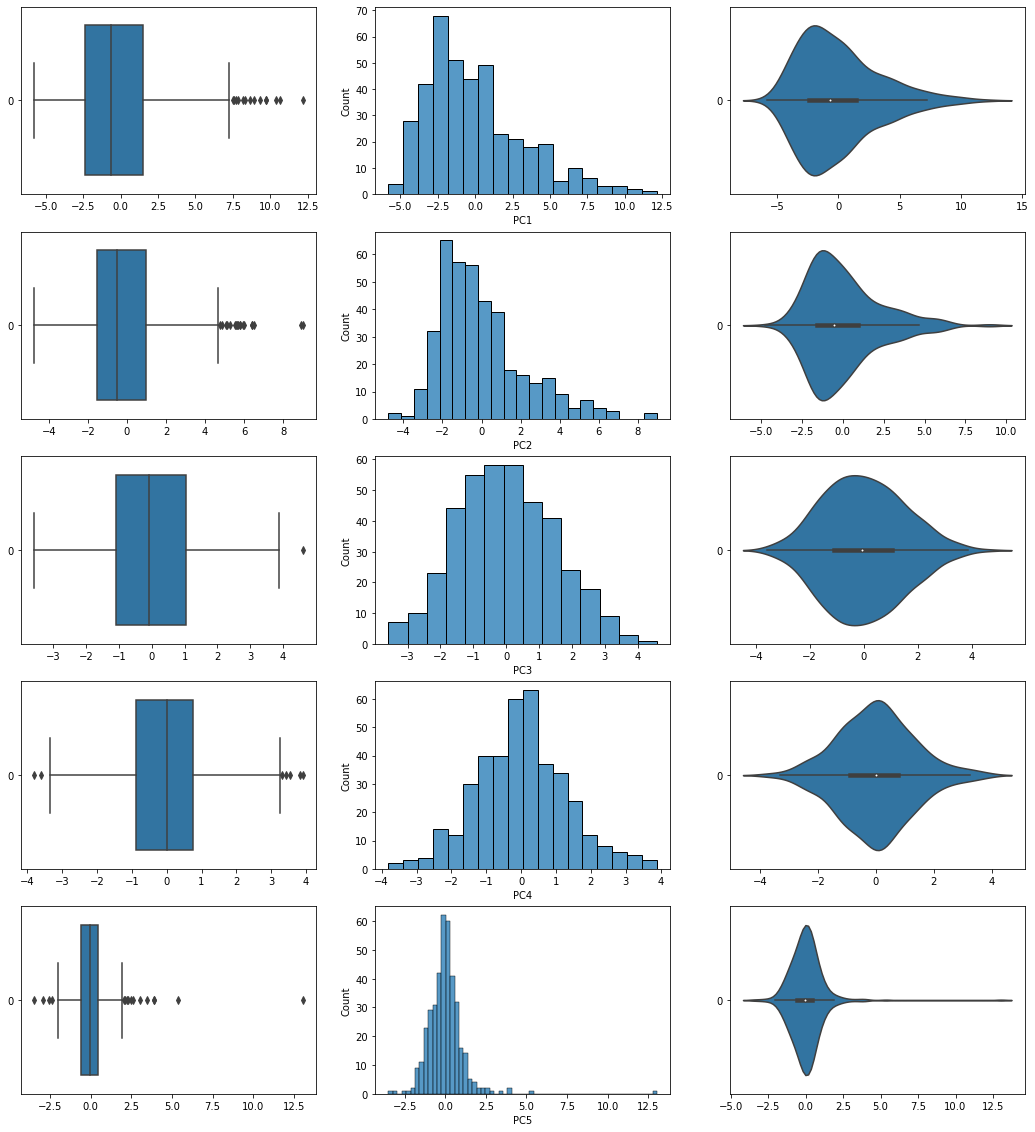

In [29]:
# Draw the distributions of all variables
f, axes = plt.subplots(5, 3, figsize=(18, 20))

count = 0
for var in df:
    sns.boxplot(data = df[var], orient = "h", ax = axes[count,0])
    sns.histplot(data = df[var], ax = axes[count,1])
    sns.violinplot(data = df[var], orient = "h", ax = axes[count,2])
    count += 1